### 🛰️위성 이미지 분류

In [1]:
# 데이터셋 로드
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

# Tensorflow dataset
import tensorflow_datasets as tfds

In [2]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR = 'dataset/'
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                      shuffle_files=True,
                                       # 튜플형식으로 return
                                      as_supervised=True,
                                      with_info=True,
                                      data_dir=DATA_DIR)

In [3]:
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image',

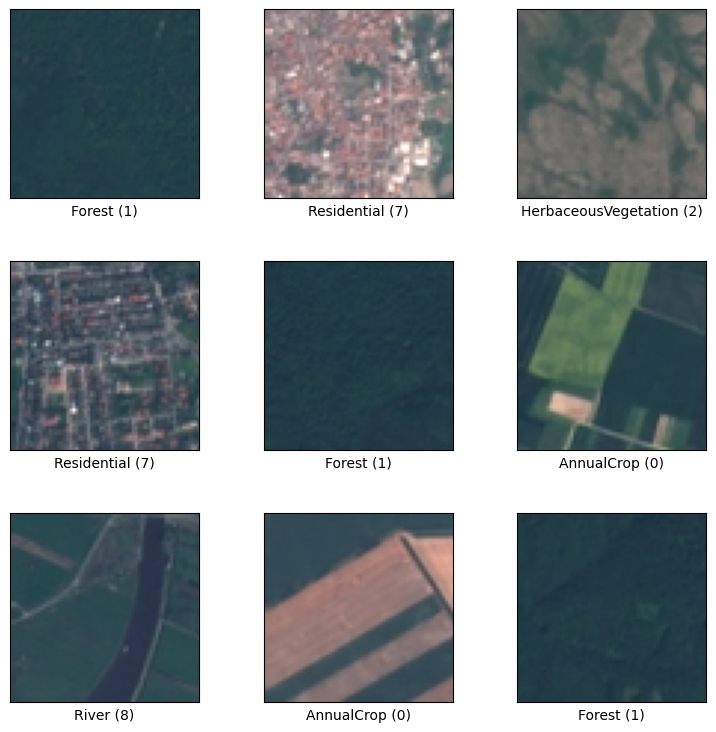

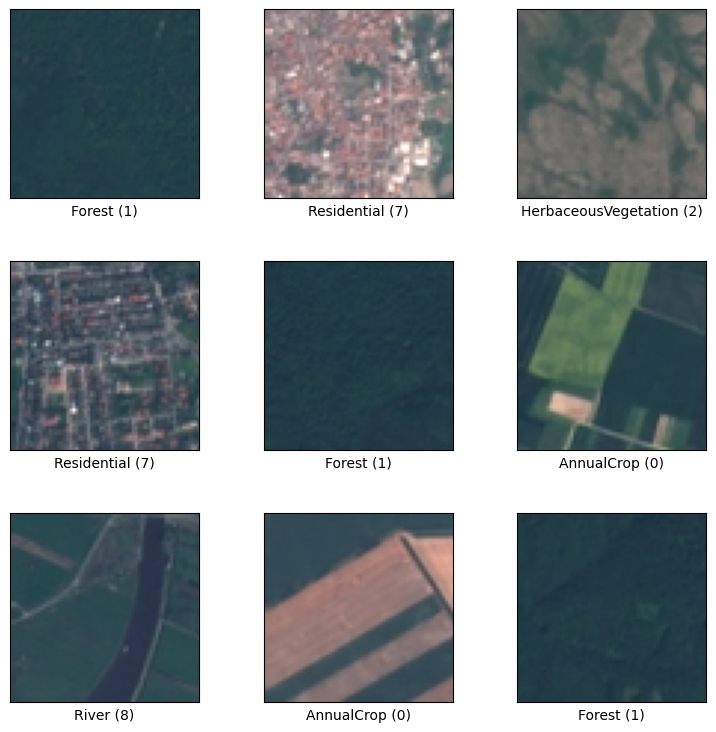

In [5]:
# 데이터확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

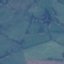
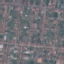
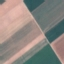
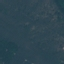
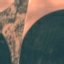
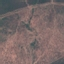
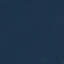
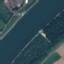
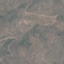
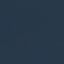

In [6]:
# as_dataframe 함수 사용
tfds.as_dataframe(valid_ds.take(10), info)

In [7]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [8]:
info.features['label'].int2str(6)

'PermanentCrop'

In [9]:
# 데이터 전처리
BATCH_SIZE = 64

# buffer_size만큼 data를 채우고 random sampling하여 새로운 data로 바꿈
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0 ~ 1 정규화
    return image, label

In [10]:
train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
print(train_data)
print(valid_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [12]:
# 모델 훈련 및 검증
def build_model():
    model = tf.keras.Sequential([
        # tf.keras.layers.Input(shape=(64, 64, 3)),
        # Convolution Layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Classifier Output Layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    return model

In [13]:
model = build_model()

In [14]:
model.compile(optimizer='adam',
             metrics=['acc'],
             loss='sparse_categorical_crossentropy')

In [15]:
history = model.fit(train_data,
                    validation_data=valid_data,
                   epochs=50)

Epoch 1/50
338/338 [==============================] - 47s 137ms/step - loss: 1.6637 - acc: 0.4136 - val_loss: 1.8220 - val_acc: 0.3931
Epoch 2/50
338/338 [==============================] - 50s 147ms/step - loss: 1.3347 - acc: 0.5241 - val_loss: 0.9799 - val_acc: 0.6767
Epoch 3/50
338/338 [==============================] - 62s 185ms/step - loss: 1.1479 - acc: 0.5909 - val_loss: 0.8771 - val_acc: 0.7406
Epoch 4/50
338/338 [==============================] - 70s 208ms/step - loss: 1.0521 - acc: 0.6248 - val_loss: 0.7562 - val_acc: 0.7557
Epoch 5/50
338/338 [==============================] - 55s 162ms/step - loss: 0.9510 - acc: 0.6674 - val_loss: 0.6971 - val_acc: 0.7706
Epoch 6/50
338/338 [==============================] - 63s 188ms/step - loss: 0.8747 - acc: 0.6949 - val_loss: 0.6709 - val_acc: 0.7856
Epoch 7/50
338/338 [==============================] - 68s 201ms/step - loss: 0.8186 - acc: 0.7173 - val_loss: 0.5941 - val_acc: 0.8169
Epoch 8/50
338/338 [==============================] - 5

In [19]:
import pandas as pd
history_df = pd.DataFrame(history.history)

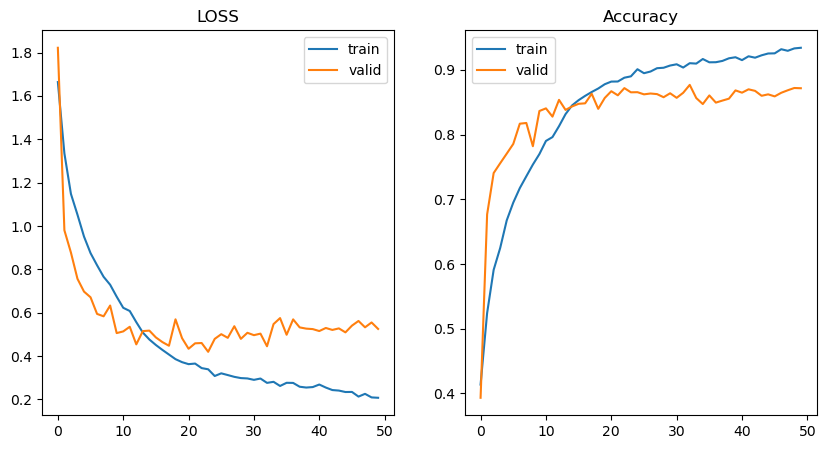

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(['train', 'valid'])
plt.title('LOSS')

plt.subplot(1, 2, 2)
plt.plot(history_df.acc)
plt.plot(history_df.val_acc)
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.show()

✔️train보다 valid의 loss가 더 높고 accuracy가 낮으므로 `과대적합`이라 할 수 있다.

In [35]:
# 데이터 증강
# sample image
image_batch, label_batch = next(iter(train_data.take(1)))

In [65]:
image = image_batch[2]
label = label_batch[2].numpy()

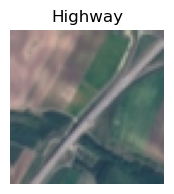

In [66]:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.title(info.features['label'].int2str(label))
plt.axis('off')
plt.show()

In [67]:
# 데이터 증강 전후 비교하는 시각화 함수
def plot_augmentation(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')
    
    plt.show()

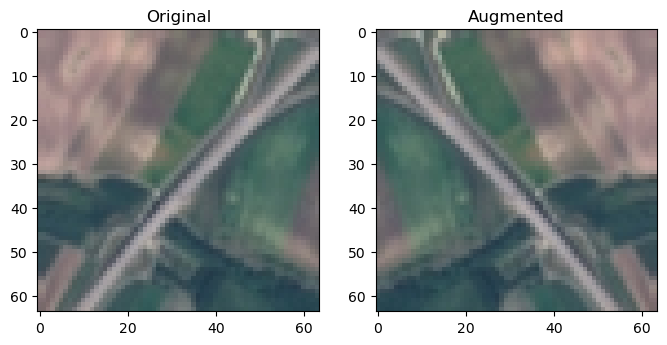

In [68]:
# flip_left_right : 이미지를 좌우 방향으로 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

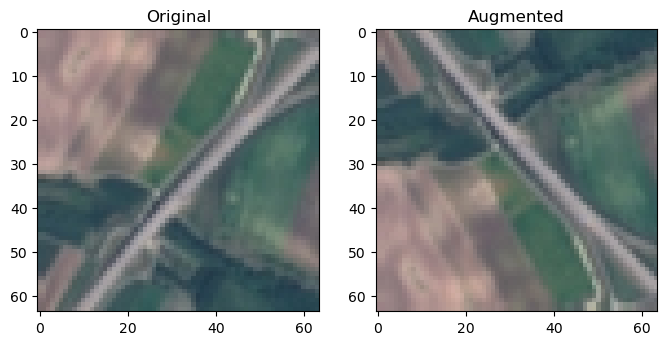

In [69]:
# flip_up_down : 이미지를 상하 방향으로 뒤집는 방법
uf_flip = tf.image.flip_up_down(image)
plot_augmentation(image, uf_flip)

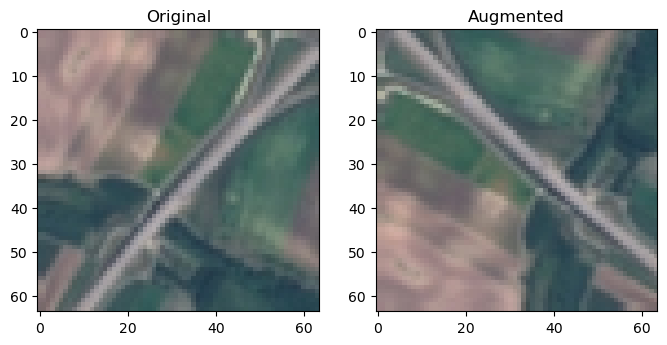

In [70]:
# rot90 : 이미지를 반시계 방향으로 90도 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

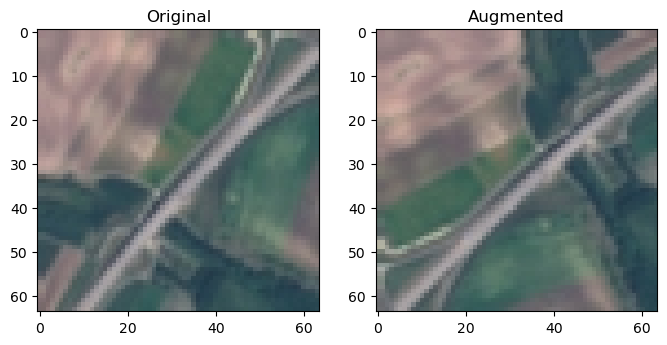

In [71]:
# transpose : 이미지 텐서 행렬의 행과 열의 위치를 바꿔줌
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

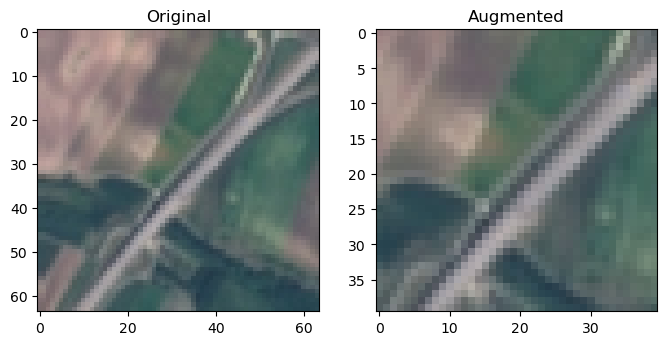

In [73]:
# central_crop : 이미지의 중심에서 일정 부분을 잘라냄
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

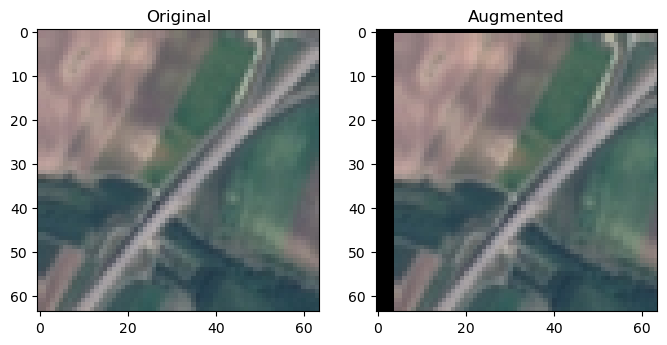

In [74]:
# resize_with_crop_or_pad : 이미지 크기 키우기
# random_crop : 이미지의 원본 크기와 같게 자름 => 상하좌우 랜덤한 방향으로 shift
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20)
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

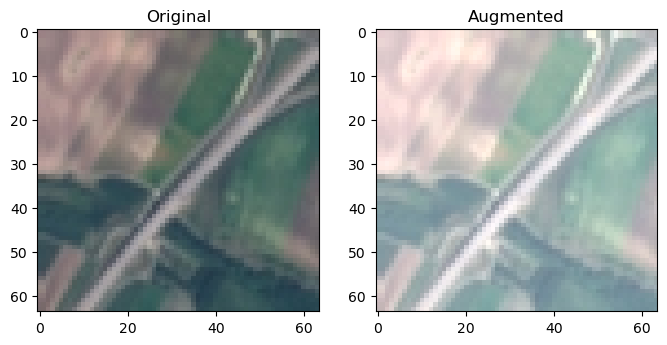

In [78]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

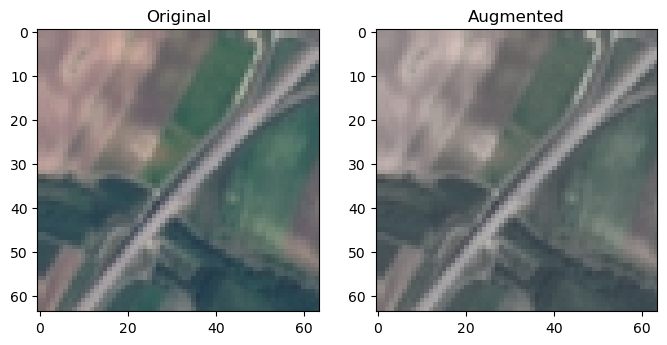

In [79]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

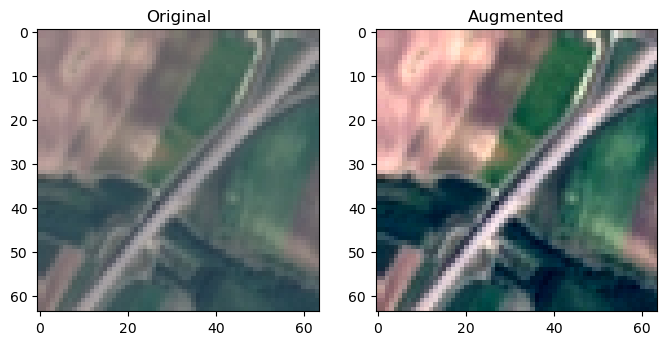

In [80]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [81]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_crop(image, size=[64, 64, 3])
    
    image = tf.cast(image, tf.float32) / 255.
    
    return image, label

In [82]:
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [83]:
print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [94]:
# Create model
aug_model = build_model()

In [95]:
# Compile model
aug_model.compile(optimizer='adam',
                 metrics=['acc'],
                 loss='sparse_categorical_crossentropy')

In [96]:
# Training model
history = aug_model.fit(train_aug,
             validation_data=valid_aug,
             epochs=20)

Epoch 1/20
338/338 [==============================] - 48s 136ms/step - loss: 1.8809 - acc: 0.2976 - val_loss: 1.6926 - val_acc: 0.3537
Epoch 2/20
338/338 [==============================] - 49s 144ms/step - loss: 1.6161 - acc: 0.3590 - val_loss: 1.3638 - val_acc: 0.4787
Epoch 3/20
338/338 [==============================] - 63s 185ms/step - loss: 1.4648 - acc: 0.4229 - val_loss: 1.2974 - val_acc: 0.4904
Epoch 4/20
338/338 [==============================] - 67s 197ms/step - loss: 1.3734 - acc: 0.4642 - val_loss: 1.1263 - val_acc: 0.5670
Epoch 5/20
338/338 [==============================] - 52s 153ms/step - loss: 1.3075 - acc: 0.5031 - val_loss: 1.0630 - val_acc: 0.6248
Epoch 6/20
338/338 [==============================] - 61s 178ms/step - loss: 1.2434 - acc: 0.5311 - val_loss: 0.9640 - val_acc: 0.6804
Epoch 7/20
338/338 [==============================] - 69s 203ms/step - loss: 1.1853 - acc: 0.5578 - val_loss: 0.9558 - val_acc: 0.6619
Epoch 8/20
338/338 [==============================] - 5

In [97]:
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,1.880917,0.297639,1.692577,0.353704
1,1.616050,0.358981,1.363846,0.478704
2,1.464827,0.422917,1.297448,0.490370
3,1.373425,0.464167,1.126339,0.567037
4,1.307492,0.503148,1.063013,0.624815
5,1.243392,0.531065,0.964009,0.680370
6,1.185293,0.557778,0.955769,0.661852
7,1.162290,0.565417,0.921963,0.678333
8,1.097352,0.595833,0.911690,0.682778
9,1.024707,0.631019,0.856699,0.714074


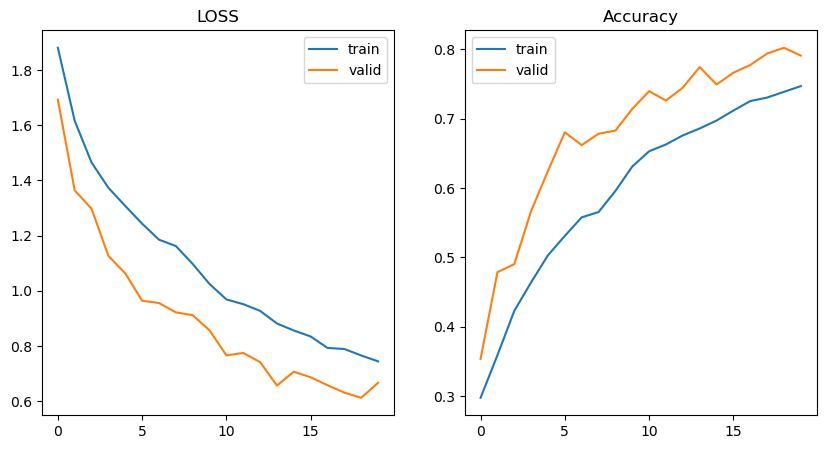

In [98]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df.loss)
plt.plot(history_df.val_loss)
plt.legend(['train', 'valid'])
plt.title('LOSS')

plt.subplot(1, 2, 2)
plt.plot(history_df.acc)
plt.plot(history_df.val_acc)
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.show()

In [99]:
# ResNet 사전 학습 모델
from tensorflow.keras.applications import ResNet50V2

![ResNet](https://www.researchgate.net/publication/344341113/figure/fig3/AS:938601894387715@1600791538743/Architectures-of-the-best-fine-tuning-models-namely-VGG16-ResNet50V2-and-DenseNet169.png)

In [100]:
pre_trained_base = ResNet50V2(
    # 기존 ResNet 모델의 Top층 제거
    include_top=False,
    weights='imagenet',
    input_shape=[64, 64, 3])

94668760/94668760 [==============================] - 7s 0us/step


In [101]:
# 사전 학습된 가중치 업데이트 X
pre_trained_base.trainable = False

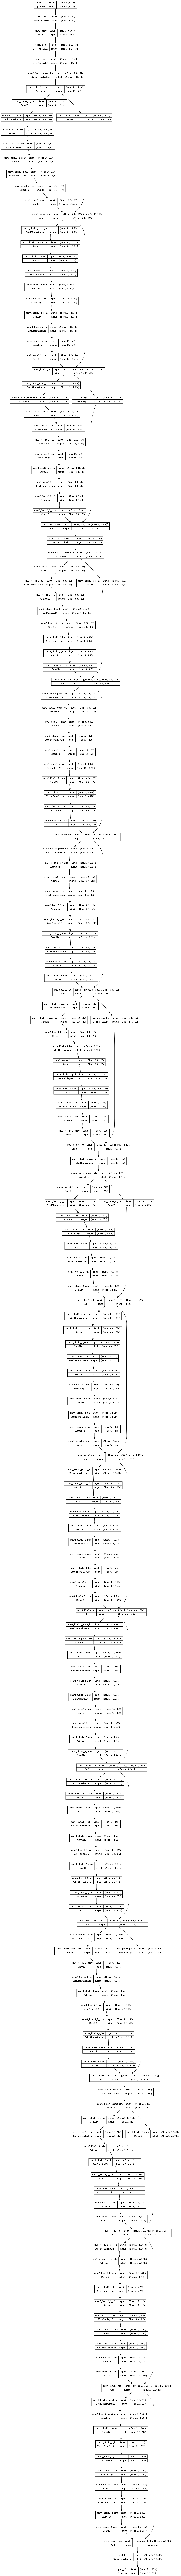

In [105]:
# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True)

In [106]:
# Top 층에 Classifier 추가
def build_trainsfer_classifier():
    model = tf.keras.Sequential([
        pre_trained_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [107]:
tc_model = build_trainsfer_classifier()

In [108]:
tc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 10)               

In [109]:
tc_model.compile(optimizer='adam',
                metrics=['acc'],
                loss='sparse_categorical_crossentropy')

In [110]:
tc_history = tc_model.fit(train_aug,
                         validation_data=valid_aug,
                         epochs=20)

Epoch 1/20
338/338 [==============================] - 93s 266ms/step - loss: 1.0258 - acc: 0.6692 - val_loss: 0.6018 - val_acc: 0.8067
Epoch 2/20
338/338 [==============================] - 107s 314ms/step - loss: 0.7337 - acc: 0.7679 - val_loss: 0.5439 - val_acc: 0.8194
Epoch 3/20
338/338 [==============================] - 115s 340ms/step - loss: 0.6456 - acc: 0.7946 - val_loss: 0.5007 - val_acc: 0.8326
Epoch 4/20
338/338 [==============================] - 178s 526ms/step - loss: 0.5941 - acc: 0.8086 - val_loss: 0.4814 - val_acc: 0.8419
Epoch 5/20
338/338 [==============================] - 203s 600ms/step - loss: 0.5649 - acc: 0.8156 - val_loss: 0.4583 - val_acc: 0.8446
Epoch 6/20
338/338 [==============================] - 213s 630ms/step - loss: 0.5402 - acc: 0.8255 - val_loss: 0.4564 - val_acc: 0.8467
Epoch 7/20
338/338 [==============================] - 166s 488ms/step - loss: 0.5217 - acc: 0.8298 - val_loss: 0.4448 - val_acc: 0.8535
Epoch 8/20
338/338 [=============================

KeyboardInterrupt: 

In [111]:
tc_df = pd.DataFrame(tc_history)
tc_df

NameError: name 'tc_history' is not defined